<>:33: SyntaxWarning: invalid escape sequence '\;'
<>:33: SyntaxWarning: invalid escape sequence '\;'
/tmp/ipykernel_875063/1368942868.py:33: SyntaxWarning: invalid escape sequence '\;'
  axs[1].set_title("SDE Force $F(x) = -D \; \dfrac{\mathrm{d}A}{\mathrm{d}x} $")
/home/dbersano/folie/folie/base.py:115: UserWarning: Trying to unpickle estimator ModelOverlay from version 0.1+15.g0e82fd9.dirty when using version 0.1+17.ga1f63d8.dirty. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn("Trying to unpickle estimator {0} from version {1} when " "using version {2}. This might lead to breaking code or " "invalid results. Use at your own risk.".format(self.__class__.__name__, pickle_version, __version__), UserWarning)
/home/dbersano/folie/folie/base.py:115: UserWarning: Trying to unpickle estimator BSplinesFunction from version 0.1+15.g0e82fd9.dirty when using version 0.1+17.ga1f63d8.dirty. This might lead to breaking code or invalid results. Use at yo

[  5.16551195 -12.73133217  12.79743762  -5.31803489   0.49631686
   0.49873382   0.50442212   0.4986971 ]


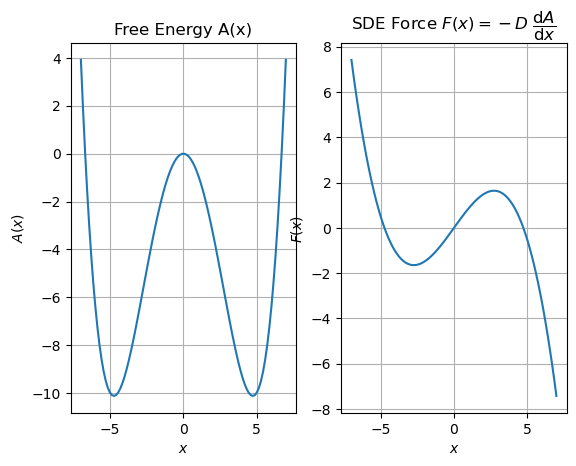

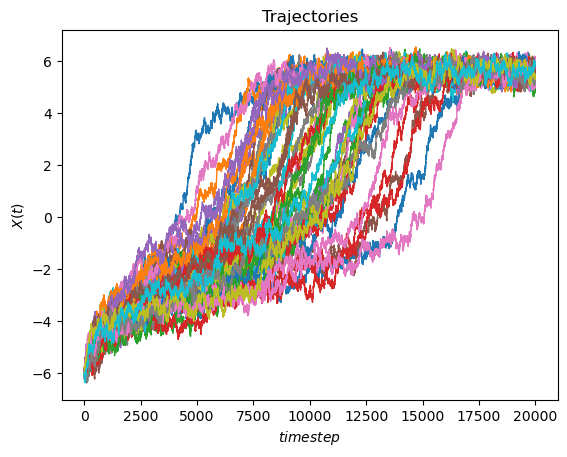

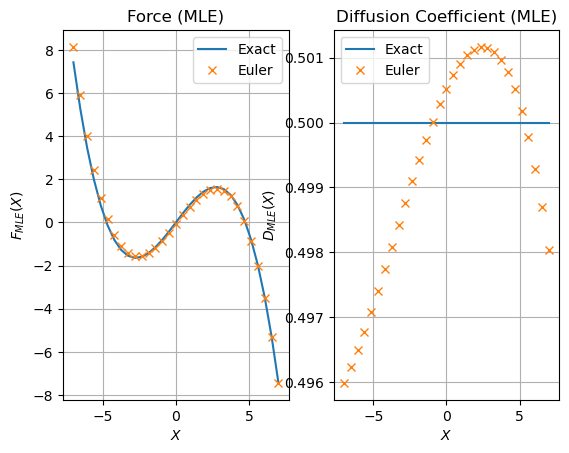

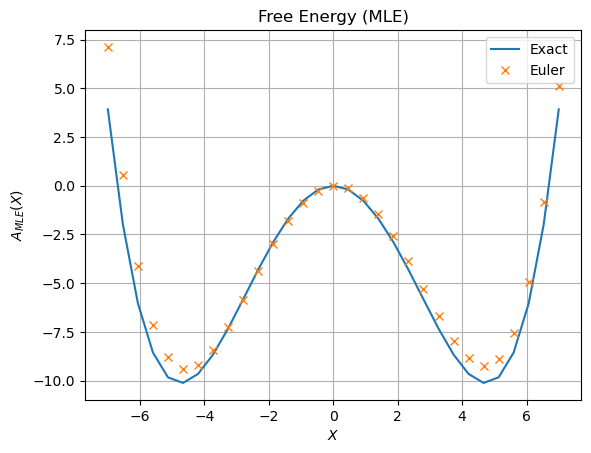

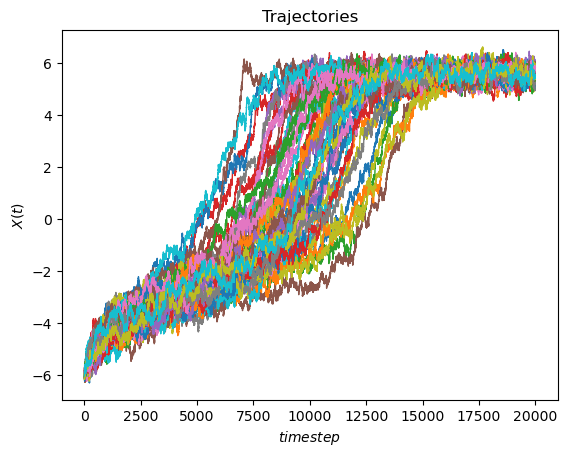

[  4.09582984 -11.88210684  12.98101765  -5.74920717   0.49357283
   0.50850171   0.49848618   0.50170006]
[  4.9910983  -13.14653486  13.89566088  -6.28106841   0.49248966
   0.51020347   0.48929914   0.50314517]
[  4.8199691  -12.55223925  12.91836672  -5.41727116   0.51676295
   0.47891859   0.51054095   0.49507819]


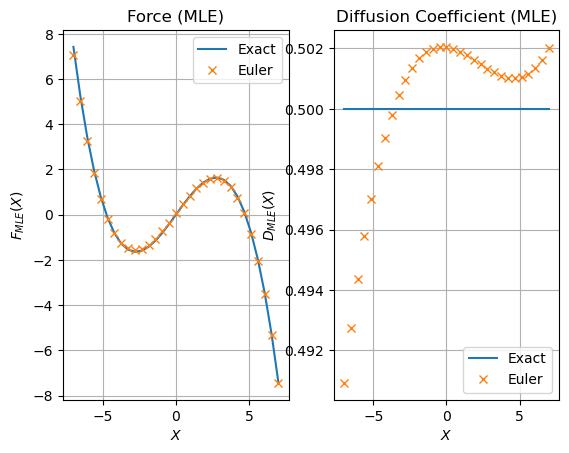

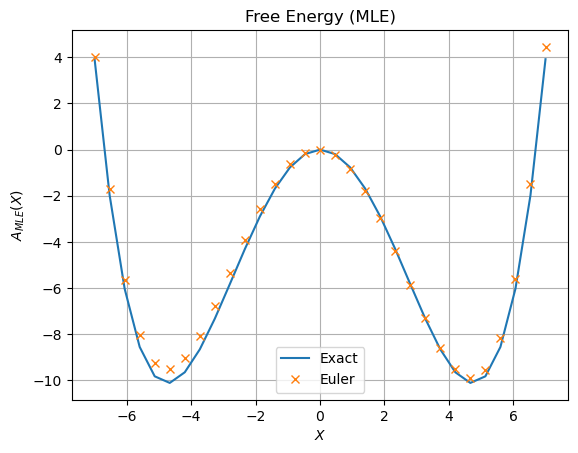

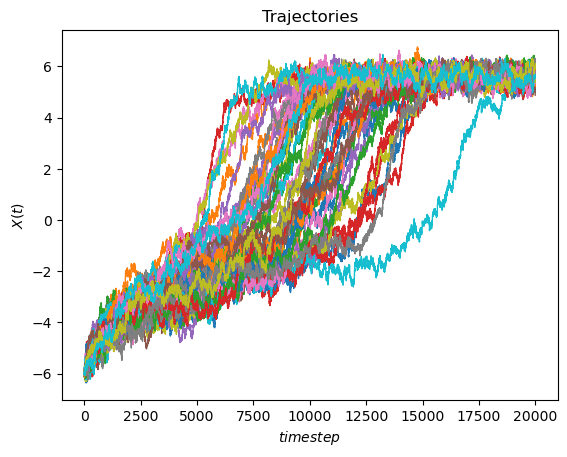

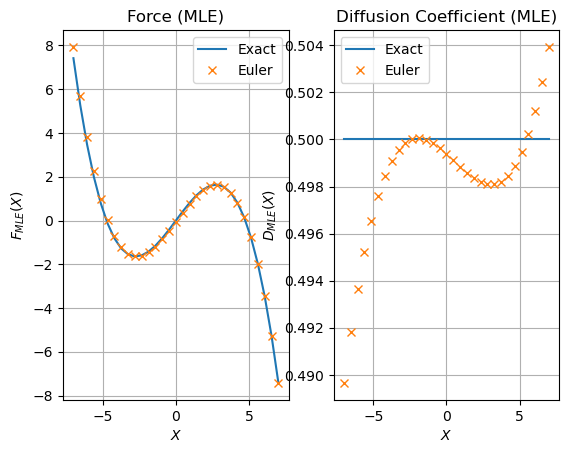

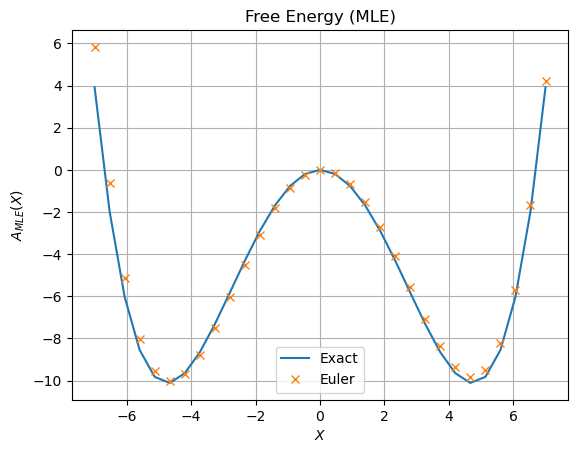

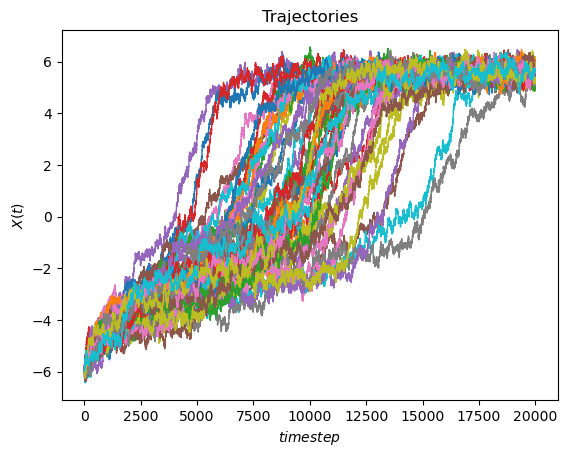

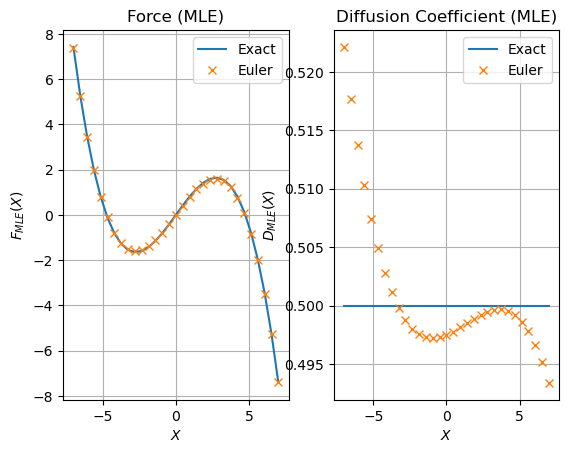

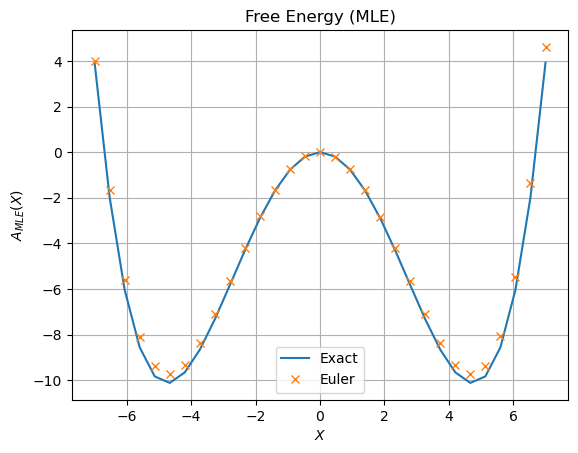

In [66]:
"""
================================
1D  Biased Double Well to generate plots to put in the report
================================

Estimation of an overdamped Langevin.
"""


import numpy as np
import matplotlib.pyplot as plt
import folie as fl
from copy import deepcopy

free_energy_coeff = 0.2 * np.array([0, 0, -4.5, 0, 0.1])
free_energy = np.polynomial.Polynomial(free_energy_coeff)
D = np.array([0.5])

force_coeff = D*np.array([-free_energy_coeff[1], -2 * free_energy_coeff[2], -3 * free_energy_coeff[3], -4 * free_energy_coeff[4]])

force_function = fl.functions.Polynomial(deg=3, coefficients=force_coeff)
diff_function = fl.functions.Polynomial(deg=0, coefficients=D)

# Plot of Free Energy and Force
x_values = np.linspace(-7, 7, 100)
fig, axs = plt.subplots(1, 2)
axs[0].plot(x_values, free_energy(x_values))
axs[1].plot(x_values, force_function(x_values.reshape(len(x_values), 1)))
axs[0].set_title("Free Energy A(x)")
axs[0].set_xlabel("$x$")
axs[0].set_ylabel("$A(x)$")
axs[0].grid()
axs[1].set_title("SDE Force $F(x) = -D \; \dfrac{\mathrm{d}A}{\mathrm{d}x} $")
axs[1].set_xlabel("$x$")
axs[1].set_ylabel("$ F(x) $ ")
axs[1].grid()

# Define model to simulate and type of simulator to use
dt = 1e-3
model_simu = fl.models.overdamped.Overdamped(deepcopy(force_function), diffusion=deepcopy(diff_function))
simulator = fl.simulations.ABMD_Simulator(fl.simulations.EulerStepper(model_simu), dt,k=10.0,xstop=6)

###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
#
#                                                                                SET OF DATA NUMBER 1
#
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################

# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = -6
# Calculate Trajectory
time_steps = 20000
data1 = deepcopy(simulator).run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data1):
    axs.plot(trj["x"],linewidth = 1)
    axs.set_title("Trajectories")
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$X(t)$")
    axs.grid()


fig, axs = plt.subplots(1, 2)
fig, axb = plt.subplots()
axs[0].set_title("Force (MLE)")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$F_{MLE}(X)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient (MLE)")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$D_{MLE}(X)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 31)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")

axb.set_title("Free Energy (MLE)")
axb.set_xlabel("$X$")
axb.set_ylabel("$A_{MLE}(X)$")
axb.grid()
axb.plot(xfa, free_energy(xfa.reshape(-1, 1)), label="Exact")

n_knots= 4
domain = fl.MeshedDomain.create_from_range(np.linspace(data1.stats.min , data1.stats.max , n_knots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=True)
res_vec1=[]
fes1=[]
KM_Estimator = fl.KramersMoyalEstimator(deepcopy(trainmodel))
res_KM = KM_Estimator.fit_fetch(deepcopy(data1))
for name,marker, transitioncls in zip(
    ["Euler", "Elerian", "Kessler", "Drozdov"],
    ["x", "1","2","3","|"],
    [
        fl.EulerDensity,
        # fl.ElerianDensity,
        # fl.KesslerDensity,
        # fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodel)),n_jobs=4)
    res = estimator.fit_fetch(deepcopy(data1),coefficients0=res_KM.coefficients)
    print(res.coefficients)
    res.remove_bias()
    fes = fl.analysis.free_energy_profile_1d(res,xfa)
    res_vec1.append(deepcopy(res))
    fes1.append(deepcopy(fes))

    axs[0].plot(xfa,res.force(xfa.reshape(-1,1)),marker,label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)),marker, label=name)
    axb.plot(xfa, fes-fes[15],marker, label=name)
axb.legend()  
axs[0].legend()
axs[1].legend()


###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
#
#                                                                                SET OF DATA NUMBER 2
#
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################

# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = -6
# Calculate Trajectory
time_steps = 20000
data2 = deepcopy(simulator).run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data2):
    axs.plot(trj["x"],linewidth = 1)
    axs.set_title("Trajectories")
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$X(t)$")
    axs.grid()

plt.show()                                 ############################################### here plt.show()
fig, axs = plt.subplots(1, 2)
fig, axb = plt.subplots()
axs[0].set_title("Force (MLE)")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$F_{MLE}(X)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient (MLE)")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$D_{MLE}(X)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 31)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")

axb.set_title("Free Energy (MLE)")
axb.set_xlabel("$X$")
axb.set_ylabel("$A_{MLE}(X)$")
axb.grid()
axb.plot(xfa, free_energy(xfa.reshape(-1, 1)), label="Exact")

n_knots= 4
domain = fl.MeshedDomain.create_from_range(np.linspace(data2.stats.min , data2.stats.max , n_knots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=True)
res_vec2=[]
fes2=[]
KM_Estimator = fl.KramersMoyalEstimator(deepcopy(trainmodel))
res_KM = KM_Estimator.fit_fetch(deepcopy(data2))
for name,marker, transitioncls in zip(
    ["Euler", "Elerian", "Kessler", "Drozdov"],
    ["x", "1","2","3","|"],
    [
        fl.EulerDensity,
        # fl.ElerianDensity,
        # fl.KesslerDensity,
        # fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodel)),n_jobs=4)
    res = estimator.fit_fetch(deepcopy(data2),coefficients0=res_KM.coefficients)
    print(res.coefficients)
    res.remove_bias()
    fes = fl.analysis.free_energy_profile_1d(res,xfa)
    res_vec2.append(deepcopy(res))
    fes2.append(deepcopy(fes))

    axs[0].plot(xfa,res.force(xfa.reshape(-1,1)),marker,label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)),marker, label=name)
    axb.plot(xfa, fes-fes[15],marker, label=name)
axb.legend()  
axs[0].legend()
axs[1].legend()

###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
#
#                                                                                SET OF DATA NUMBER 3
#
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################

# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = -6
# Calculate Trajectory
time_steps = 20000
data3 = deepcopy(simulator).run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data3):
    axs.plot(trj["x"],linewidth = 1)
    axs.set_title("Trajectories")
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$X(t)$")
    axs.grid()


fig, axs = plt.subplots(1, 2)
fig, axb = plt.subplots()
axs[0].set_title("Force (MLE)")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$F_{MLE}(X)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient (MLE)")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$D_{MLE}(X)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 31)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")

axb.set_title("Free Energy (MLE)")
axb.set_xlabel("$X$")
axb.set_ylabel("$A_{MLE}(X)$")
axb.grid()
axb.plot(xfa, free_energy(xfa.reshape(-1, 1)), label="Exact")

n_knots= 4
domain = fl.MeshedDomain.create_from_range(np.linspace(data3.stats.min , data3.stats.max , n_knots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=True)
res_vec3=[]
fes3=[]
KM_Estimator = fl.KramersMoyalEstimator(deepcopy(trainmodel))
res_KM = KM_Estimator.fit_fetch(deepcopy(data3))
for name,marker, transitioncls in zip(
    ["Euler", "Elerian", "Kessler", "Drozdov"],
    ["x", "1","2","3","|"],
    [
        fl.EulerDensity,
        # fl.ElerianDensity,
        # fl.KesslerDensity,
        # fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodel)),n_jobs=4)
    res = estimator.fit_fetch(deepcopy(data3),coefficients0=res_KM.coefficients)
    print(res.coefficients)
    res.remove_bias()
    fes = fl.analysis.free_energy_profile_1d(res,xfa)
    res_vec3.append(deepcopy(res))
    fes3.append(deepcopy(fes))

    axs[0].plot(xfa,res.force(xfa.reshape(-1,1)),marker,label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)),marker, label=name)
    axb.plot(xfa, fes-fes[15],marker, label=name)
axb.legend()  
axs[0].legend()
axs[1].legend()

###############################################################################################################################################################################################################
###############################################################################################################################################################################################################
#
#                                                                                SET OF DATA NUMBER 4
#
###############################################################################################################################################################################################################
###############################################################################################################################################################################################################

# initialize positions
ntraj = 50
q0 = np.empty(ntraj)
for i in range(len(q0)):
    q0[i] = -6
# Calculate Trajectory
time_steps = 20000
data4 = deepcopy(simulator).run(time_steps, q0, save_every=1)

# Plot resulting Trajectories
fig, axs = plt.subplots()
for n, trj in enumerate(data4):
    axs.plot(trj["x"],linewidth = 1)
    axs.set_title("Trajectories")
    axs.set_xlabel("$timestep$")
    axs.set_ylabel("$X(t)$")
    axs.grid()


fig, axs = plt.subplots(1, 2)
fig, axb = plt.subplots()
axs[0].set_title("Force (MLE)")
axs[0].set_xlabel("$X$")
axs[0].set_ylabel("$F_{MLE}(X)$")
axs[0].grid()

axs[1].set_title("Diffusion Coefficient (MLE)")
axs[1].set_xlabel("$X$")
axs[1].set_ylabel("$D_{MLE}(X)$")
axs[1].grid()

xfa = np.linspace(-7.0, 7.0, 31)
axs[0].plot(xfa, model_simu.force(xfa.reshape(-1, 1)), label="Exact")
axs[1].plot(xfa, model_simu.diffusion(xfa.reshape(-1, 1)), label="Exact")

axb.set_title("Free Energy (MLE)")
axb.set_xlabel("$X$")
axb.set_ylabel("$A_{MLE}(X)$")
axb.grid()
axb.plot(xfa, free_energy(xfa.reshape(-1, 1)), label="Exact")

n_knots= 4
domain = fl.MeshedDomain.create_from_range(np.linspace(data4.stats.min , data4.stats.max , n_knots).ravel())
trainmodel = fl.models.Overdamped(force=fl.functions.BSplinesFunction(domain), has_bias=True)
res_vec4=[]
fes4=[]
KM_Estimator = fl.KramersMoyalEstimator(deepcopy(trainmodel))
res_KM = KM_Estimator.fit_fetch(deepcopy(data4))
for name,marker, transitioncls in zip(
    ["Euler", "Elerian", "Kessler", "Drozdov"],
    ["x", "1","2","3","|"],
    [
        fl.EulerDensity,
        # fl.ElerianDensity,
        # fl.KesslerDensity,
        # fl.DrozdovDensity,
    ],
):
    estimator = fl.LikelihoodEstimator(transitioncls(deepcopy(trainmodel)),n_jobs=4)
    res = estimator.fit_fetch(deepcopy(data4),coefficients0=res_KM.coefficients)
    print(res.coefficients)
    res.remove_bias()
    fes = fl.analysis.free_energy_profile_1d(res,xfa)
    res_vec4.append(deepcopy(res))
    fes4.append(deepcopy(fes))
    axs[0].plot(xfa,res.force(xfa.reshape(-1,1)),marker,label=name)
    axs[1].plot(xfa, res.diffusion(xfa.reshape(-1, 1)),marker, label=name)
    axb.plot(xfa, fes-fes[15],marker, label=name)
axb.legend()  
axs[0].legend()
axs[1].legend()



[1.41200498 0.92497002 0.55290496 0.28187424 0.1446689  0.1971105
 0.28533643 0.3485132  0.38368398 0.3951725  0.38839909 0.36880976
 0.34158722 0.31148593 0.28259705 0.25794977 0.23900787 0.22538483
 0.21516799 0.20580468 0.19503416 0.18145363 0.16469792 0.1454074
 0.12515327 0.10642085 0.09253297 0.08676876 0.09020649 0.10167487
 0.1235525 ]


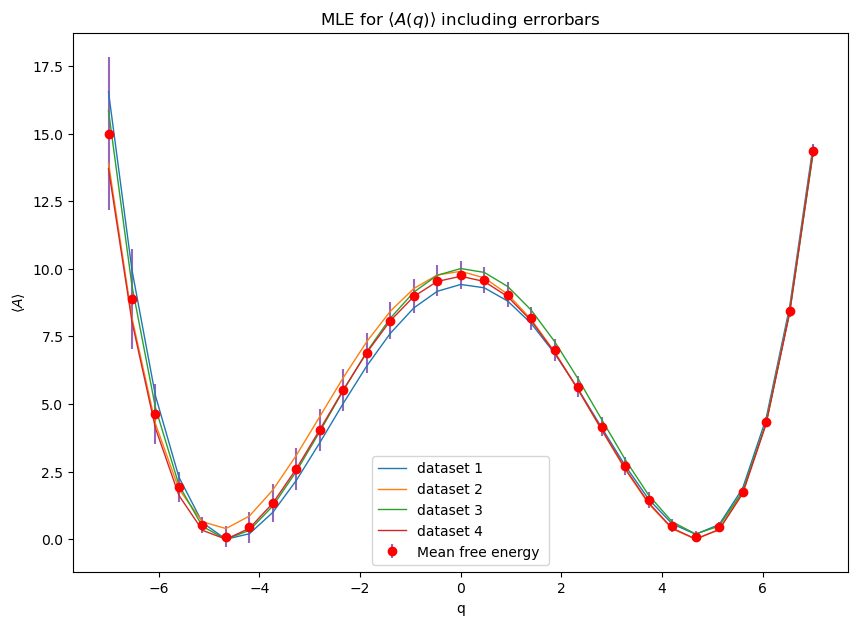

In [77]:
mean_fes=np.empty_like(fes)

for i in range(len(fes)): #sum over xfa points
    sum=0
    sum+=(fes1[0][i]+fes2[0][i]+fes3[0][i]+fes4[0][i]) # sum over the replicas for the jth estimator
    mean_fes[i]= sum/4
# plt.scatter(xfa,mean_fes,marker='2')

var_fes=np.empty_like(fes)
err =np.empty_like(var_fes)
for i in range(len(fes)):
     sum = ((fes1[0][i]-mean_fes[i])**2+(fes2[0][i]-mean_fes[i])**2 + (fes3[0][i]-mean_fes[i])**2 + (fes4[0][i]-mean_fes[i])**2 ) # sum over the replicas for the jth estimator 
     var_fes[i]= sum/3

err = np.sqrt(var_fes)
fig, ax =plt.subplots(figsize=(10,7))
ax.errorbar(xfa,mean_fes,yerr=2*err,fmt='o',color ='red', ecolor='C4',alpha=1, label="Mean free energy ")
ax.set_xlabel('q')
ax.set_ylabel('$\\langle A \\rangle$')
ax.set_title("MLE for $\\langle A (q)\\rangle$ including errorbars")


ax.plot(xfa,fes1[0],label ='dataset 1',linewidth=1)
ax.plot(xfa,fes2[0],label ='dataset 2',linewidth=1)
ax.plot(xfa,fes3[0],label ='dataset 3',linewidth=1)
ax.plot(xfa,fes4[0],label ='dataset 4',linewidth=1)


# ax.scatter(xfa,fes1,marker='x',s=50,label ='dataset 1')
# ax.scatter(xfa,fes2,marker='1',s=50,label ='dataset 2')
# ax.scatter(xfa,fes3,marker='2',s=50,label ='dataset 3')
# ax.scatter(xfa,fes4,marker='3',s=50,label ='dataset 4')

ax.legend()
    # var_fes[i]= (fes1[i]**2+fes2[i]**2+fes3[i]**2+fes4[i]**2)/4 - mean_fes[i]**2
print(err)

In [78]:
mean_fes=np.empty_like(fes)

for i in range(len(fes)): #sum over xfa points
    sum=0
    for j in range(4):  #sum over estmator Euler kessler & company
        sum+=(fes1[j][i]+fes2[j][i]+fes3[j][i]+fes4[j][i]) # sum over the replicas for the jth estimator
    mean_fes[i]= sum/16
plt.plot(xfa,mean_fes)

var_fes=np.empty_like(fes)
err =np.empty_like(var_fes)
for i in range(len(fes)):
     sum=0
     for j in range(4):  #sum over estmator Euler kessler & company
        sum+=(fes1[j][i]**2+fes2[j][i]**2+fes3[j][i]**2+fes4[j][i]**2) # sum over the replicas for the jth estimator 
        var_fes[i]= sum/16 - mean_fes[i]**2
        err = np.sqrt(var_fes)

plt.errorbar(xfa,mean_fes,yerr=err)
    # var_fes[i]= (fes1[i]**2+fes2[i]**2+fes3[i]**2+fes4[i]**2)/4 - mean_fes[i]**2

IndexError: list index out of range